In [11]:
import os
import anaconfig

from Preprocessing.preprocessing import load_dataframes

from utils.plotutils.plotconfig import configure_matplotlib
from utils.commonutils.cfeatures import get_unnormalised_features

from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch

configure_matplotlib()

In [12]:
hits_particles, particles = load_dataframes(
    indir="/scratch/acorreia/minbias-sim10b-xdigi-nospillover/92",
)
hits = hits_particles.drop_duplicates(["event", "hit_id"])

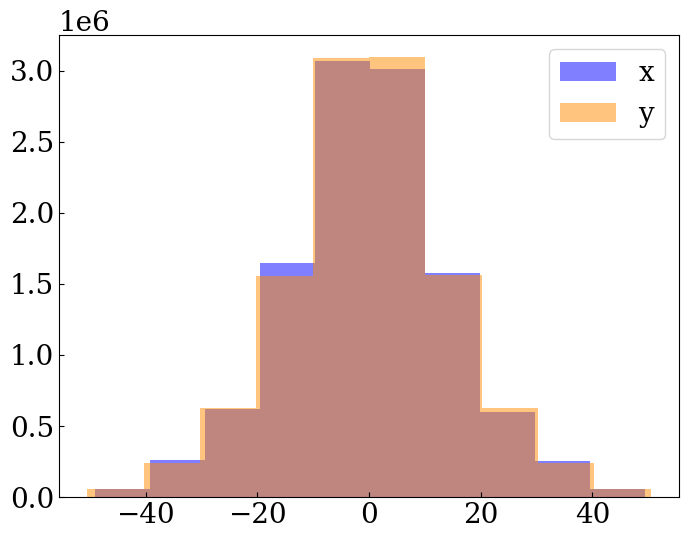

In [13]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(hits_particles["x"], alpha=0.5, color="b", label="x")
ax.hist(hits_particles["y"], alpha=0.5, color="darkorange", label="y")
ax.legend()


In [14]:
print("mean:", hits_particles["x"].mean())
print("std:", hits_particles["x"].std())
print("mean:", hits_particles["y"].mean())
print("std:", hits_particles["y"].std())

mean: -0.08074610279141962
std: 14.51331843142442
mean: 0.02629636994005264
std: 14.760759458144337


In [15]:
slopes_xz = []
slopes_yz = []
zdiffs = []

train_dir = "/scratch/acorreia/data/track-edges/metric_learning_processed/train"
for filename in tqdm(os.listdir(train_dir)[:1000]):
    path = os.path.join(train_dir, filename)
    batch = torch.load(path, map_location="cpu")
    start, end = batch.edge_index
    r, phi, z = get_unnormalised_features(
        batch=batch,
        path_or_config="../pipeline_configs/track-edges.yaml",
        feature_names=["r", "phi", "z"],
    )
    x = r * np.cos(phi)
    y = r * np.sin(phi)
    z_edge_index = batch.z[batch.edge_index]
    batch.edge_index = batch.edge_index[:, z_edge_index[0] != z_edge_index[1]]

    xe = x[batch.edge_index]
    ye = y[batch.edge_index]
    ze = z[batch.edge_index]
    
    slopes_xz.append(
        ((ye[1] - ye[0]) / (ze[1] - ze[0])).numpy()
    )
    slopes_yz.append(
        ((xe[1] - xe[0]) / (ze[1] - ze[0])).numpy()
    )
    zdiffs.append(ze[1] - ze[0])
    

  0%|          | 0/1000 [00:00<?, ?it/s]

In [16]:
array_slopes_xz = np.concatenate(slopes_xz, axis=0)
array_slopes_yz = np.concatenate(slopes_yz, axis=0)
zdiffs = np.concatenate(zdiffs, axis=0)


In [17]:
array_angles_xz = np.arctan(array_slopes_xz)
array_angles_yz = np.arctan(array_slopes_yz)


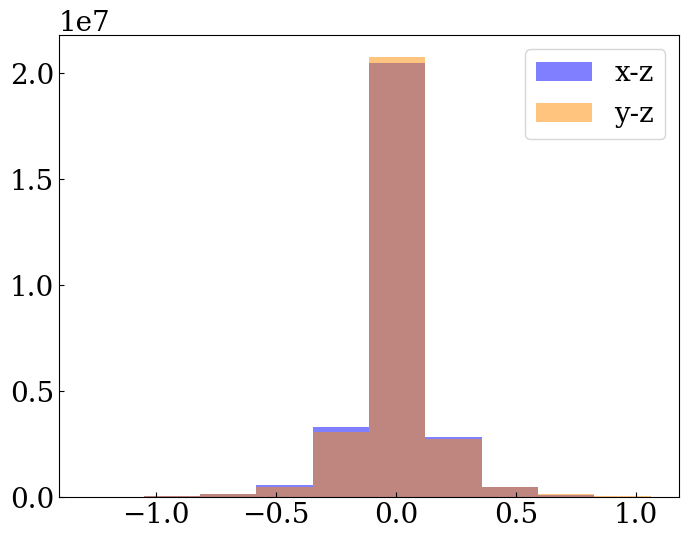

In [18]:
fig, ax = plt.subplots(figsize=(8, 6))
_, edges, _ = ax.hist(array_angles_xz, alpha=0.5, color="b", label="x-z")
ax.hist(array_slopes_yz, alpha=0.5, color="darkorange", label="y-z", bins=edges)
ax.legend()


In [19]:
print("mean:", array_slopes_xz.mean())
print("std:", array_slopes_xz.std())
print("mean:", array_slopes_yz.mean())
print("std:", array_slopes_yz.std())

mean: -0.0065150103
std: 0.18471645
mean: 0.002169753
std: 0.16960813


In [9]:
print("mean:", array_angles_xz.mean())
print("std:", array_angles_xz.std())
print("mean:", array_angles_yz.mean())
print("std:", array_angles_yz.std())

mean: -0.0049208854
std: 0.16074418
mean: 0.0019381851
std: 0.15437067


In [10]:
print("mean:", zdiffs.mean())
print("std:", zdiffs.std())

mean: 74.665184
std: 64.93781
